In [1]:
# !nvidia-smi


Wed Aug 31 10:47:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# import pdb
# def processme(name):
#   pdb.set_trace()
#   when = 'today'
#   print(name, ' is using google colab', when)

# processme('ionut')

In [5]:
import torch, pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [18]:
# function to display a grid that shows fake img vs real img
def show(tensor, ch=1, size=(28,28), num=16):  
  #tensor: 128(pictures @time or batch size) x 784(28*28)
  # we are using the cpu for visualisation
  data = tensor.detach().cpu().view(-1,ch,*size) # reshape the 784 to be  128 x 1(chanel size) x 28 X 28
  grid = make_grid(data[:num], row=4).permute(1,2,0) # change order of the image to aid matplotlib 1 x 28 x 28 = 28 x 28 x 1
  plt.imshow(grid)
  plt.show()

Coding the hyperparameters and Dataloader

In [20]:
# setup of main parameters and hyperparameters
epochs = 500
cur_step = 0
info_step = 300 # show information every 300 steps within one epoch
mean_gen_loss = 0
mean_disc_loss = 0

z_dim = 64
lr = 0.00001 # learning rate
loss_func = nn.BCEWithLogitsLoss() # BinaryCrossEntropy loss function
bs = 128 #bach size
device = 'cuda'

dataloader = DataLoader(MNIST('.', download=True, transform=transforms.ToTensor()),shuffle=True, batch_size=bs)
# Nr of Steps = total images in the dataset(MNIST) / Batch_size.  60000/128=468.75


Declare Models

In [31]:
# Generator

def genBlock(inp,out):
  return nn.Sequential(
      nn.Linear(inp,out),
      nn.BatchNorm1d(out), # because we are using single chanel images 1D, black and white
      nn.ReLU(inplace=True), # sets negative values to 0 and lets only positive values throug
)
  
class Generator(nn.Module):
  def __init__(self, z_dim=64, i_dim=784, h_dim=128):
    super().__init__()
    self.gen = nn.Sequential(
        genBlock(z_dim, h_dim), # size  enter 64 exit 128 (recive a noise vector of size 64)
        genBlock(h_dim, h_dim*2), # 128 to 256
        genBlock(h_dim*2, h_dim*4), # 256 to 512
        genBlock(h_dim*4, h_dim*8), # 512 to 1024
        nn.Linear(h_dim*8, i_dim), # 1024 to 784(28x28) (produce an output image of size 784)
        nn.Sigmoid(), # set values between 0 and 1
    )

  def forward(self,noise):
    return self.gen(noise)

def gen_noise(number, z_dim):
  # stocastic function that returns a tensor field 
  # with random numbers from a normal distribution 
  # with a mean of 0 and variance of 1 (Standard Normal Distribution)
  return torch.randn(number,z_dim).to(device)

# Discriminator

def discBlock(inp, out):
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.LeakyReLU(0.2), # non linear function to give small negative value to negative numbers
  )

class Discriminator(nn.Module):
  def __init__(self, i_dim=784, h_dim=256):
    super().__init__()
    self.disc = nn.Sequential(
        discBlock(i_dim,h_dim*4), # 784 to 1024
        discBlock(h_dim*4,h_dim*2),# 1024 to 512
        discBlock(h_dim*2, h_dim),# 512, 256
        nn.Linear(h_dim, 1) # 256 to 1

    )

  def forward(self, image):
    return self.disc(image)
    

Code the Optimizer

In [32]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [14]:
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [15]:
disc

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([2, 6, 9, 8, 5, 0, 2, 3, 9, 6])


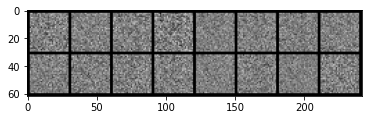

In [33]:
x,y = next(iter(dataloader))
print(x.shape, y.shape)
print(y[:10])

noise = gen_noise(bs, z_dim)
fake = gen(noise)
show(fake)

In [34]:
# calculate loss

# generator loss

def calc_gen_loss(loss_func, gen, disc, number, z_dim):
  noise = gen_noise(number, z_dim)
  fake = gen(noise)
  pred = disc(fake)
  targets = torch.ones_like(pred) # ceates a tensor with dimensionality similar to the prediction and fill it with ones
  gen_loss = loss_func(pred, targets)
  return gen_loss 

# discriminator loss
def calc_disc_loss(loss_func, gen, disc, number, real, z_dim):
  noise = gen_noise(number, z_dim)
  fake = gen(noise)
  disc_fake = disc(fake.detach())
  disc_fake_targets=torch.zeros_like(disc_fake)
  disc_fake_loss = loss_func(disc_fake, disc_fake_targets)

  disc_real = disc(real)
  disc_real_targets = torch.ones_like(disc_real)
  disc_real_loss = loss_func(disc_real, disc_real_targets)

  disc_loss=(disc_fake_loss+disc_real_loss)/2

  return disc_loss


In [ ]:
# trainig

for epoch in range(epochs):
  for real, _ in tqdm(dataloader):
    ### train discriminator
    disc_opt.zero_grad()

    cur_bs = len(real) #real = 128 * 1 * 28 * 28
    real = real.view(cur_bs, -1) # reshape 128 * 784
    real = real.to(device)

    disc_loss = calc_disc_loss(loss_func, gen, disc, cur_bs, real, z_dim)

    disc_loss.backward(retain_graph=True)
    disc_opt.step()

    ### train generator
    gen_opt.zero_grad()
    gen_loss = calc_gen_loss(loss_func, gen, disc, cur_bs, z_dim)
    gen_loss.backward(retain_graph=True)
    gen_opt.step()

    #visualisation & stats
    mean_disc_loss += disc_loss.item()/info_step
    mean_gen_loss += gen_loss.item()/info_step

    if cur_step % info_step == 0 and cur_step>0:
      fake_noise = gen_noise(cur_bs, z_dim)
      fake = gen(fake_noise)
      show(fake)
      show(real)
      print(f"{epoch}: step {cur_step} / Gen loss: {mean_gen_loss} / disc_loss: {mean_disc_loss}")
      mean_gen_loss, mean_disc_loss = 0,0
    cur_step += 1